# Gender Recognition Using Custom CNN, HOG and Facial Landmarks

## Code by: Archisha Sinha

# Making Smaller Dataset

In [1]:
import os
import shutil
import random
from glob import glob

In [2]:
# Original dataset paths
dataset_path = '/kaggle/input/gender-dataset'
train_male_dir = '/kaggle/input/gender-dataset/Dataset/Train/Male'
train_female_dir = '/kaggle/input/gender-dataset/Dataset/Train/Female'
validation_male_dir = '/kaggle/input/gender-dataset/Dataset/Validation/Male'
validation_female_dir = '/kaggle/input/gender-dataset/Dataset/Validation/Female'
test_male_dir = '/kaggle/input/gender-dataset/Dataset/Test/Male'
test_female_dir = '/kaggle/input/gender-dataset/Dataset/Test/Female'

In [3]:
# New dataset path to save the smaller dataset
small_dataset_path = '/kaggle/working/small_gender_dataset'
os.makedirs(small_dataset_path, exist_ok=True)

# Function to create directories and copy images
def create_subset(source_dir, dest_dir, sample_size):
    os.makedirs(dest_dir, exist_ok=True)
    all_images = glob(os.path.join(source_dir, '*.jpg'))
    sampled_images = random.sample(all_images, sample_size)
    for img_path in sampled_images:
        shutil.copy(img_path, dest_dir)

In [4]:
# Creating subsets for each category
create_subset(train_male_dir, os.path.join(small_dataset_path, 'Train/Male'), 50)
create_subset(train_female_dir, os.path.join(small_dataset_path, 'Train/Female'), 50)
create_subset(validation_male_dir, os.path.join(small_dataset_path, 'Validation/Male'), 20)
create_subset(validation_female_dir, os.path.join(small_dataset_path, 'Validation/Female'), 20)
create_subset(test_male_dir, os.path.join(small_dataset_path, 'Test/Male'), 5)
create_subset(test_female_dir, os.path.join(small_dataset_path, 'Test/Female'), 5)

print("Subset created at:", small_dataset_path)

Subset created at: /kaggle/working/small_gender_dataset


In [5]:
import shutil

# Path to the smaller dataset
small_dataset_path = '/kaggle/working/small_gender_dataset'
# Output zip file path
output_zip_path = '/kaggle/working/small_gender_dataset.zip'

# Zip the folder
shutil.make_archive(small_dataset_path, 'zip', small_dataset_path)

print("Dataset zipped at:", output_zip_path)


Dataset zipped at: /kaggle/working/small_gender_dataset.zip


# Work flow

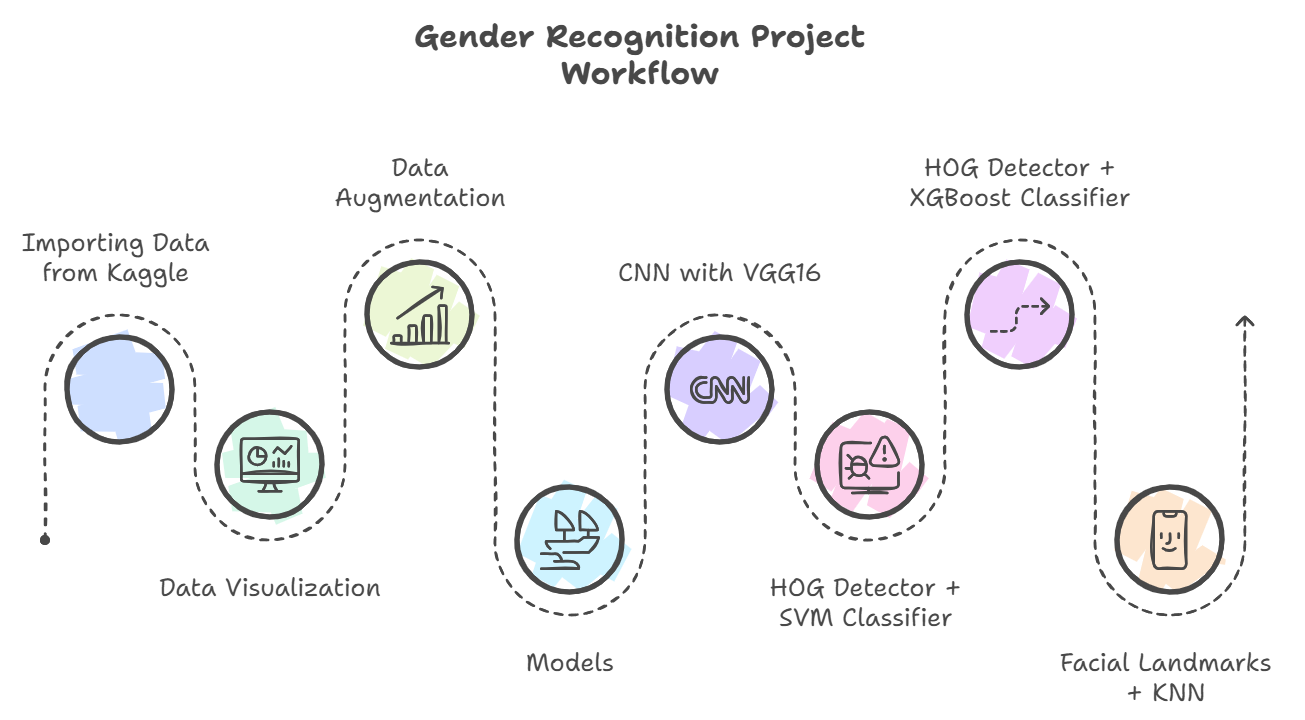

## Introduction

- Gender recognition from facial images is a rapidly evolving research area within computer vision, driven by applications in security, human-computer interaction, and targeted advertising. 
- Accurately identifying gender based on facial features requires effective feature extraction and classification techniques that can capture distinct visual patterns. 
- Two prominent methods in this domain are Histogram of Oriented Gradients (HOG) and Convolutional Neural Networks (CNNs).
- Both techniques aim to extract meaningful features from images but differ significantly in their approach and performance.


# 3 Approaches

#### 1. CNN with VGG 16
#### 2. HOG with SVM and XGBoost
#### 3. Facial Landmarks with KNN

# Importing necessary Libraries

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from glob import glob
from skimage.feature import hog
from xgboost import XGBClassifier

# Dataset paths

In [2]:
# Define paths to dataset directories
dataset_path = '/kaggle/input/smaller-gender-dataset/small_gender_dataset'
train_male_dir = os.path.join(dataset_path, '/kaggle/input/smaller-gender-dataset/small_gender_dataset/Train/Male')
train_female_dir = os.path.join(dataset_path, '/kaggle/input/smaller-gender-dataset/small_gender_dataset/Train/Female')
validation_male_dir = os.path.join(dataset_path, '/kaggle/input/smaller-gender-dataset/small_gender_dataset/Validation/Male')
validation_female_dir = os.path.join(dataset_path, '/kaggle/input/smaller-gender-dataset/small_gender_dataset/Validation/Female')
test_male_dir = os.path.join(dataset_path, '/kaggle/input/smaller-gender-dataset/small_gender_dataset/Test/Male')
test_female_dir = os.path.join(dataset_path, '/kaggle/input/smaller-gender-dataset/small_gender_dataset/Test/Female')

# Exploratory Data Analysis

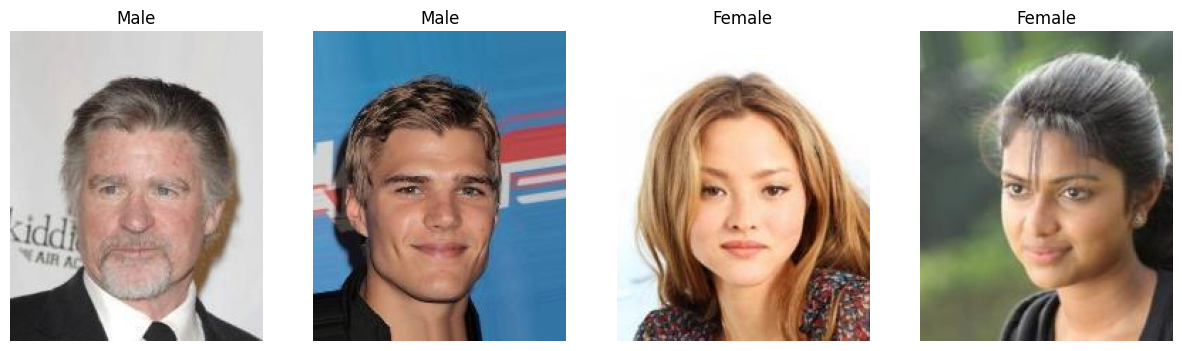

In [3]:
# Load and visualize a few images from the dataset
def load_and_visualize_samples(male_dir, female_dir):
    male_images = [cv2.imread(img) for img in glob(os.path.join(male_dir, '*.jpg'))[:2]]
    female_images = [cv2.imread(img) for img in glob(os.path.join(female_dir, '*.jpg'))[:2]]
    images = male_images + female_images
    labels = ['Male', 'Male', 'Female', 'Female']
    
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, img in enumerate(images):
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(labels[i])
        axs[i].axis('off')
    plt.show()

load_and_visualize_samples(train_male_dir, train_female_dir)

In [4]:
# Data Preprocessing with Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   #shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

validation_test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
target_size = (64, 64)

# Load data generators

In [66]:
# Load data generators
train_generator = train_datagen.flow_from_directory(os.path.join(dataset_path, 'Train'),
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = validation_test_datagen.flow_from_directory(os.path.join(dataset_path, 'Validation'),
                                                                   target_size=target_size,
                                                                   batch_size=batch_size,
                                                                   class_mode='binary')

test_generator = validation_test_datagen.flow_from_directory(os.path.join(dataset_path, 'Test'),
                                                             target_size=target_size,
                                                             batch_size=batch_size,
                                                             class_mode='binary')


Found 100 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


# Visualizing Augmented Images

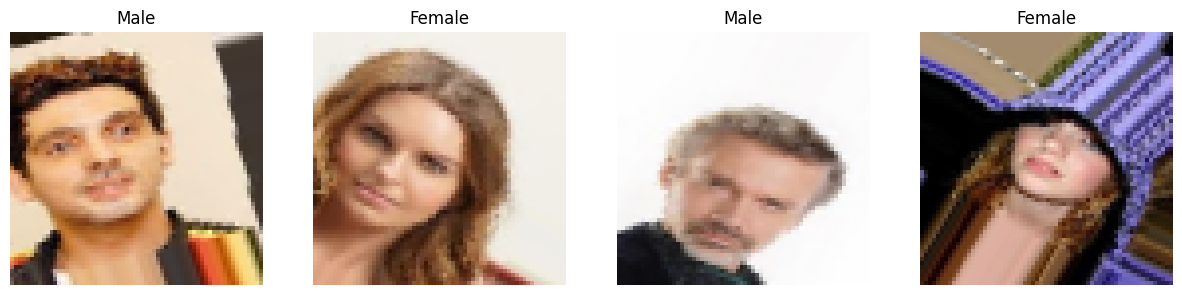

In [38]:

def visualize_augmented_images(generator):
    images, labels = next(generator)
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i in range(4):
        axs[i].imshow(images[i])
        axs[i].set_title("Female" if labels[i] == 0 else "Male")
        axs[i].axis('off')
    plt.show()

visualize_augmented_images(train_generator)

# Model 1: CNN with VGG16

- Pretrained VGG16 model was used as the base for feature extraction, with only the last four layers set as trainable.
- Added custom layers (Flatten, Dense, Dropout) to adapt for binary gender classification.
- Used data augmentation and trained with binary cross-entropy loss, optimizing using Adam.

In [67]:
# Model 1: CNN with VGG16
base_model = VGG16(input_shape=(64, 64, 3), include_top=False, weights="imagenet")

for layer in base_model.layers[:-4]:
    layer.trainable = False

model_vgg16 = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model_vgg16.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])


In [68]:
# Callbacks
lrd = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.0001)
mcp = ModelCheckpoint('vgg16_model.keras', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train model
history_vgg16 = model_vgg16.fit(train_generator,
                                validation_data=validation_generator,
                                epochs=30,
                                callbacks=[lrd, mcp, es])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5681 - loss: 0.7665 - val_accuracy: 0.7000 - val_loss: 0.5326 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.5467 - loss: 0.6826 - val_accuracy: 0.8250 - val_loss: 0.5042 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.7101 - loss: 0.5549 - val_accuracy: 0.8250 - val_loss: 0.4411 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7163 - loss: 0.5494 - val_accuracy: 0.7000 - val_loss: 0.5056 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.8250 - loss: 0.4378 - val_accuracy: 0.8250 - val_loss: 0.3422 - learning_rate: 1.0000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.8613 - loss: 0.3640 - val_accuracy: 0.8250 - val_loss: 0.3084 - learning_rate: 1.0000e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7919 - loss: 0.4406 - val_ac

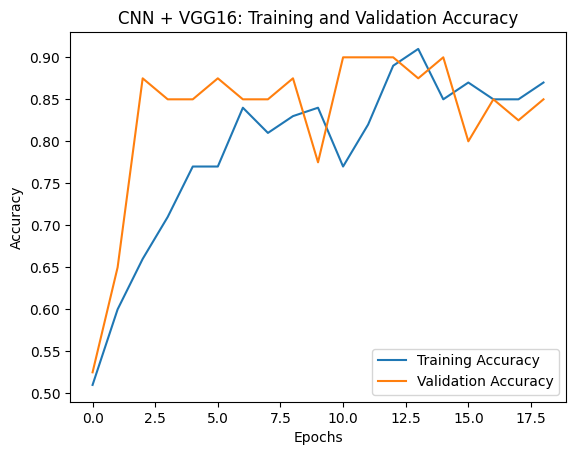

In [41]:
# Plot training & validation accuracy and loss
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN + VGG16: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

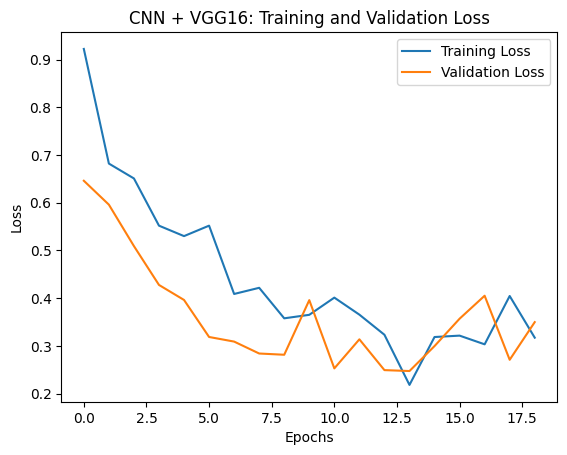

In [42]:
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('CNN + VGG16: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
# Evaluation on test set
test_loss, test_accuracy = model_vgg16.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step - accuracy: 0.8000 - loss: 0.6078
Test Accuracy: 80.00%


# Model 2: HOG + SVM

- Extracted Histogram of Oriented Gradients (HOG) features to capture the texture and shape information from images.
- Trained a linear Support Vector Machine (SVM) classifier on HOG features for gender classification.
- Evaluated model performance using classification metrics.

In [6]:
def extract_hog_features(image):
    resized_image = cv2.resize(image, (128, 128))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

In [7]:
def load_hog_data(male_dir, female_dir):
    hog_features, labels = [], []
    for label, directory in zip([0, 1], [male_dir, female_dir]):
        for img_path in glob(os.path.join(directory, '*.jpg')):
            image = cv2.imread(img_path)
            features = extract_hog_features(image)
            hog_features.append(features)
            labels.append(label)
    return np.array(hog_features), np.array(labels)

X_train_hog, y_train_hog = load_hog_data(train_male_dir, train_female_dir)
X_test_hog, y_test_hog = load_hog_data(test_male_dir, test_female_dir)

In [8]:
# SVM Model
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train_hog, y_train_hog)
y_pred_svm = svm_model.predict(X_test_hog)
print("SVM Model - Classification Report:")
print(classification_report(y_test_hog, y_pred_svm))

SVM Model - Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.67      0.80      0.73         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



# Model 3: HOG + XGBoost

- Used the same HOG features from Model 2.
- Trained an XGBoost classifier on the extracted HOG features for improved classification accuracy.
- Evaluated performance by comparing predictions with ground truth.

In [9]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_hog, y_train_hog)
y_pred_xgb = xgb_model.predict(X_test_hog)

In [10]:
print("XGBoost Model - Classification Report:")
print(classification_report(y_test_hog, y_pred_xgb))

XGBoost Model - Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.50      0.40      0.44         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.50      0.50      0.49        10



# Model 4: Facial Landmarks + KNN

- Detected faces and extracted the face region of interest (ROI) using OpenCV's Haar Cascade.
- Flattened the face ROI to form a feature vector and trained a K-Nearest Neighbors (KNN) classifier.
- Evaluated the model's performance using classification metrics to compare accuracy.

In [48]:
#!pip install dlib

In [12]:
# Download the shape predictor file if not available in the environment
import urllib.request
if not os.path.exists("shape_predictor_68_face_landmarks.dat"):
    print("Downloading the shape predictor model...")
    url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
    urllib.request.urlretrieve(url, "shape_predictor_68_face_landmarks.dat.bz2")
    # Unzip the downloaded file
    import bz2
    with bz2.BZ2File("shape_predictor_68_face_landmarks.dat.bz2") as file, open("shape_predictor_68_face_landmarks.dat", "wb") as output:
        output.write(file.read())

In [25]:
# Load OpenCV's Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_landmarks_with_opencv(image):
    # Convert image to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces using Haar Cascade
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        # For simplicity, we only extract the first detected face
        x, y, w, h = faces[0]
        
        # Extract the face region of interest (ROI)
        face_roi = gray[y:y+h, x:x+w]
        
        # Resize the face ROI to a fixed size (e.g., 100x100)
        face_resized = cv2.resize(face_roi, (100, 100))
        
        # Flatten the resized face ROI to a 1D array and return
        return face_resized.flatten()
    
    return np.zeros(10000)  # Return a zero vector if no face is detected (100x100 = 10000)

In [26]:
# Load image paths (adjust directories as per your setup)
train_male_dir = "path/to/male_images" 
train_female_dir = "path/to/female_images"
test_male_dir = "path/to/male_images_test"
test_female_dir = "path/to/female_images_test"

# Extract landmarks (face ROI) from images
X_train_landmarks = [extract_landmarks_with_opencv(cv2.imread(img)) for img in glob(train_male_dir + '/*.jpg')[:100] + glob(train_female_dir + '/*.jpg')[:100]]
y_train_landmarks = [0]*100 + [1]*100  # Male=0, Female=1

X_test_landmarks = [extract_landmarks_with_opencv(cv2.imread(img)) for img in glob(test_male_dir + '/*.jpg')[:50] + glob(test_female_dir + '/*.jpg')[:50]]
y_test_landmarks = [0]*50 + [1]*50  # Male=0, Female=1

In [27]:
# Convert lists to numpy arrays for fitting the KNN model
X_train_landmarks = np.array(X_train_landmarks)
X_test_landmarks = np.array(X_test_landmarks)

# Ensure the arrays are 2D, reshaping them if necessary (1 sample per row, features as columns)
X_train_landmarks = X_train_landmarks.reshape(X_train_landmarks.shape[0], -1)
X_test_landmarks = X_test_landmarks.reshape(X_test_landmarks.shape[0], -1)

# KNN Model on extracted face ROI
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_landmarks, y_train_landmarks)
y_pred_knn = knn_model.predict(X_test_landmarks)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [23]:
print("KNN Model - Classification Report:")
print(classification_report(y_test_landmarks, y_pred_knn))

KNN Model - Classification Report:


NameError: name 'y_pred_knn' is not defined

# Comparitive Study

In [51]:
# 1. VGG16 Model - Evaluate on the test set
test_loss, test_accuracy_vgg16 = model_vgg16.evaluate(test_generator)
y_true_vgg16 = test_generator.classes  # True labels from the test generator
y_pred_vgg16 = model_vgg16.predict(test_generator)
y_pred_vgg16 = (y_pred_vgg16 > 0.5).astype(int)  # Convert predictions to binary

# 2. HOG + SVM Model
y_pred_svm = svm_model.predict(X_test_hog)
svm_accuracy = accuracy_score(y_test_hog, y_pred_svm)
svm_precision = precision_score(y_test_hog, y_pred_svm)
svm_recall = recall_score(y_test_hog, y_pred_svm)
svm_f1 = f1_score(y_test_hog, y_pred_svm)

# 3. HOG + XGBoost Model
y_pred_xgb = xgb_model.predict(X_test_hog)
xgb_accuracy = accuracy_score(y_test_hog, y_pred_xgb)
xgb_precision = precision_score(y_test_hog, y_pred_xgb)
xgb_recall = recall_score(y_test_hog, y_pred_xgb)
xgb_f1 = f1_score(y_test_hog, y_pred_xgb)

# 4. Facial Landmarks + KNN Model
# y_pred_knn = knn_model.predict(X_test_landmarks)
# knn_accuracy = accuracy_score(y_test_landmarks, y_pred_knn)
# knn_precision = precision_score(y_test_landmarks, y_pred_knn)
# knn_recall = recall_score(y_test_landmarks, y_pred_knn)
# knn_f1 = f1_score(y_test_landmarks, y_pred_knn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8000 - loss: 0.6078
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [53]:
#create a summary dataframe
summary = pd.DataFrame({
    "Model": ["VGG16 CNN", "HOG + SVM", "HOG + XGBoost"],
    "Accuracy": [
        test_accuracy_vgg16 * 100,
        svm_accuracy * 100,
        xgb_accuracy * 100,
        #knn_accuracy * 100
    ],
    "Precision": [
        precision_score(y_true_vgg16, y_pred_vgg16),
        svm_precision,
        xgb_precision,
        #knn_precision
    ],
    "Recall": [
        recall_score(y_true_vgg16, y_pred_vgg16),
        svm_recall,
        xgb_recall,
        #knn_recall
    ],
    "F1 Score": [
        f1_score(y_true_vgg16, y_pred_vgg16),
        svm_f1,
        xgb_f1,
        #knn_f1
    ]
})

# Print the comparison summary
print(summary)

           Model   Accuracy  Precision  Recall  F1 Score
0      VGG16 CNN  80.000001   0.428571     0.6  0.500000
1      HOG + SVM  70.000000   0.666667     0.8  0.727273
2  HOG + XGBoost  50.000000   0.500000     0.4  0.444444


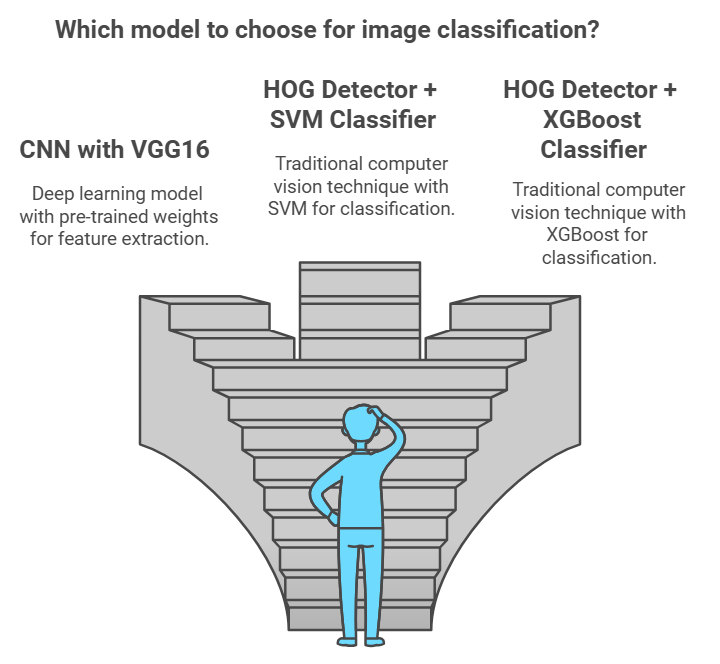

## Best Model: 
- HOG + SVM is the best model based on its high precision, recall, and F1 score. 
- Even though VGG16 CNN has the highest accuracy, HOG + SVM offers a better balance in terms of precision and recall, which is important for classification tasks with balanced or imbalanced classes.

# USER INPUT and MODEL OUTPUT

## Input Image

In [90]:
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize image to 64x64 for VGG16 and CNN-based models
    image_resized = cv2.resize(image, (64, 64))
    
    # Convert to grayscale for HOG and Facial Landmarks models
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    
    return image_resized, image_gray


In [91]:
def predict_gender_vgg16(image_path):
    image_resized, _ = preprocess_image(image_path)
    image_resized = image_resized / 255.0  # Normalize the image

    # Make prediction
    prediction = model_vgg16.predict(np.expand_dims(image_resized, axis=0))
    return "Male" if prediction > 0.5 else "Female"

In [92]:
def predict_gender_svm(image_path):
    _, image_gray = preprocess_image(image_path)
    features = extract_hog_features(image_gray)
    
    # Make prediction
    prediction = svm_model.predict([features])
    return "Male" if prediction == 1 else "Female"


In [93]:
def predict_gender_xgb(image_path):
    _, image_gray = preprocess_image(image_path)
    features = extract_hog_features(image_gray)
    
    # Make prediction
    prediction = xgb_model.predict([features])
    return "Male" if prediction == 1 else "Female"


In [94]:
# def predict_gender_knn(image_path):
#     _, image_gray = preprocess_image(image_path)
#     features = extract_landmarks_with_opencv(image_gray)
    
#     # Make prediction
#     prediction = knn_model.predict([features])
#     return "Male" if prediction == 0 else "Female"


In [99]:
def classify_gender_from_image(image_path):
    print("Predicting gender using VGG16 CNN...")
    result_vgg16 = predict_gender_vgg16(image_path)
    print(f"VGG16 CNN Prediction: {result_vgg16}")
    
    print("Predicting gender using HOG + SVM...")
    result_svm = predict_gender_svm(image_path)
    print(f"HOG + SVM Prediction: {result_svm}")
    
    print("Predicting gender using HOG + XGBoost...")
    result_xgb = predict_gender_xgb(image_path)
    print(f"HOG + XGBoost Prediction: {result_xgb}")
    
#     print("Predicting gender using Facial Landmarks + KNN...")
#     result_knn = predict_gender_knn(image_path)
#     print(f"Facial Landmarks + KNN Prediction: {result_knn}")

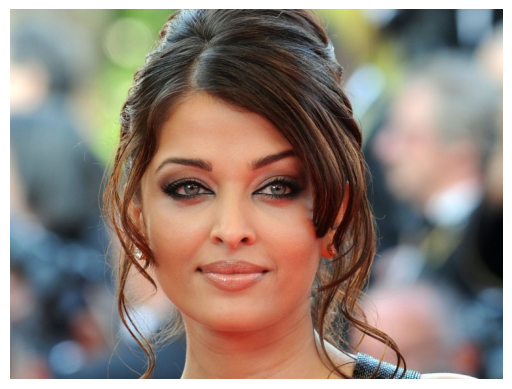

Predicting gender using VGG16 CNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
VGG16 CNN Prediction: Female
Predicting gender using HOG + SVM...
HOG + SVM Prediction: Female
Predicting gender using HOG + XGBoost...
HOG + XGBoost Prediction: Female


In [106]:
import cv2
import matplotlib.pyplot as plt

def display_image(image_path):
    # Load the image from the provided path
    image = cv2.imread(image_path)
    
    # Convert the image from BGR (OpenCV default) to RGB (for correct display in Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage

image_path = "/kaggle/input/new-images/Sensational_Expressions_Aishwarya_Rai_Nri_Gujarati_India_Gujarat_News_Photos_8427.jpg"

display_image(image_path)

classify_gender_from_image(image_path)

Sample HOG features: [0.29882309 0.23042352 0.13094424 0.01014767 0.13862903 0.27104588
 0.12180883 0.06202768 0.02587158 0.13156798]


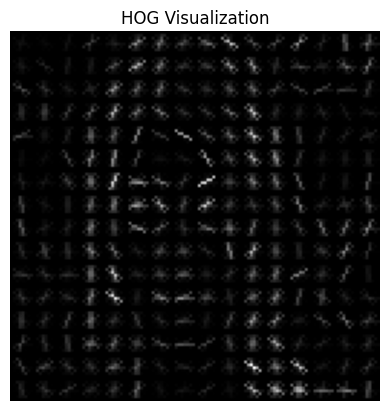

In [11]:
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt

def extract_hog_features(image):
    # Resize and convert the image to grayscale
    resized_image = cv2.resize(image, (128, 128))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features
    features, hog_image = hog(
        gray_image, 
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        visualize=True
    )
    
    # Display a few HOG features
    print("Sample HOG features:", features[:10])  # Print first 10 HOG features
    
    # Plot the HOG image for visualization
    plt.imshow(hog_image, cmap="gray")
    plt.title("HOG Visualization")
    plt.axis("off")
    plt.show()
    
    return features

# Load an example image
image = cv2.imread('/kaggle/input/new-images/Sensational_Expressions_Aishwarya_Rai_Nri_Gujarati_India_Gujarat_News_Photos_8427.jpg')  # Provide the path to your image
hog_features = extract_hog_features(image)


In [97]:
def extract_hog_features(image):
    resized_image = cv2.resize(image, (128, 128))
    
    # Check if the image is already in grayscale
    if len(resized_image.shape) == 3:  # Check if image has 3 channels (RGB)
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = resized_image  # Image is already grayscale
        
    features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features
